# **Classificação de textos do Twitter com spaCy**

# Importação e instalação das bibliotecas


In [1]:
!pip install -q spacy==2.2.3 #Atualizado: 02/05/2021 Obs: utilizar esta versão.

     |████████████████████████████████| 10.4 MB 3.8 MB/s 
     |████████████████████████████████| 3.7 MB 32.6 MB/s 
     |████████████████████████████████| 184 kB 34.8 MB/s 
     |████████████████████████████████| 2.2 MB 46.4 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
en-core-web-sm 3.3.0 requires spacy<3.4.0,>=3.3.0.dev0, but you have spacy 2.2.3 which is incompatible.


In [2]:
import spacy
spacy.__version__

'2.2.3'

In [3]:
!python3 -m spacy download pt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 21.2 MB 675 kB/s 
  Created wheel for pt-core-news-sm: filename=pt_core_news_sm-2.2.5-py3-none-any.whl size=21186281 sha256=e7932ae346e0ab6be92dcaf197bae46b59f39c01cfb431645bedda3fba48edb6
  Stored in directory: /tmp/pip-ephem-wheel-cache-cu1yvoqo/wheels/c3/f9/0c/5c014a36941a00f5df5fc0756cb961d7c457a978e697a6ce3b
Successfully built pt-core-news-sm
✔ Download and installation successful
You can now load the model via spacy.load('pt_core_news_sm')
✔ Linking successful
/usr/local/lib/python3.7/dist-packages/pt_core_news_sm -->
/usr/local/lib/python3.7/dist-packages/spacy/data/pt
You can now load the model via spacy.load('pt')


In [4]:
import pandas as pd
import string
import spacy
import random
import seaborn as sns
import numpy as np
import re

# Carregamento das bases de dados

- Link Kaggle: https://www.kaggle.com/augustop/portuguese-tweets-for-sentiment-analysis#TweetsNeutralHash.csv

# Base de treinamento

- Negative label: 0
- Positive label: 1

In [5]:
base_treinamento = pd.read_csv('/content/Train50.csv', delimiter=';')

In [6]:
base_treinamento.shape

(50000, 5)

In [7]:
base_treinamento.head()

,id,tweet_text,tweet_date,sentiment,query_used
0,1050785521201541121,@Laranjito76 A pessoa certa para isso seria o ...,Fri Oct 12 16:29:25 +0000 2018,1,:)
1,1050785431955140608,"@behin_d_curtain Para mim, é precisamente o co...",Fri Oct 12 16:29:04 +0000 2018,1,:)
2,1050785401248645120,Vou fazer um video hoje... estou pensando em f...,Fri Oct 12 16:28:56 +0000 2018,1,:)
3,1050785370982547461,"aaaaaaaa amei tanto essas polaroids, nem sei e...",Fri Oct 12 16:28:49 +0000 2018,1,:)
4,1050785368902131713,Valoriza o coração do menininho que vc tem. El...,Fri Oct 12 16:28:49 +0000 2018,1,:)


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


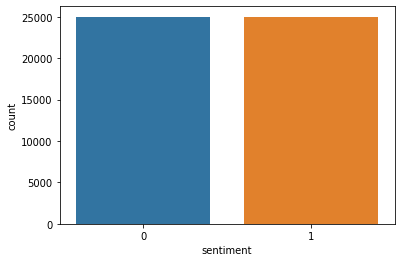

In [8]:
sns.countplot(base_treinamento['sentiment'], label = 'Contagem');

In [9]:
base_treinamento.drop(['id', 'tweet_date', 'query_used'], axis = 1, inplace=True)

In [10]:
base_treinamento.head()

,tweet_text,sentiment
0,@Laranjito76 A pessoa certa para isso seria o ...,1
1,"@behin_d_curtain Para mim, é precisamente o co...",1
2,Vou fazer um video hoje... estou pensando em f...,1
3,"aaaaaaaa amei tanto essas polaroids, nem sei e...",1
4,Valoriza o coração do menininho que vc tem. El...,1


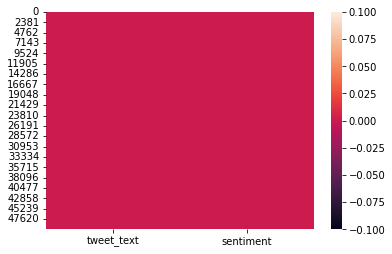

In [11]:
sns.heatmap(pd.isnull(base_treinamento));

# Base de teste

In [12]:
base_teste = pd.read_csv('/content/Test.csv', delimiter=';')

In [13]:
base_teste.head()

,id,tweet_text,tweet_date,sentiment,query_used
0,1029536486021099522,@Gazo1a Nossa! Muito obrigada :),Wed Aug 15 01:13:20 +0000 2018,1,:)
1,1029536496368406528,@BerzGamer vai pa puta que te pariu :),Wed Aug 15 01:13:23 +0000 2018,1,:)
2,1029536531655131137,QUER MAIS DESCONTOS? (14/08) ⭐⭐⭐⭐⭐ 🌐 Confira n...,Wed Aug 15 01:13:31 +0000 2018,1,:)
3,1029536560117678081,"EU VOU PEGAR VCS, ME AJUDEM GALERA, PELO AMOR ...",Wed Aug 15 01:13:38 +0000 2018,1,:)
4,1029536605852377088,Estávamos em casa do Zé e eu estava a morrer d...,Wed Aug 15 01:13:49 +0000 2018,1,:)


In [14]:
base_teste.shape

(5000, 5)

In [15]:
base_teste.drop(['id', 'tweet_date', 'query_used'], axis = 1, inplace=True)

In [16]:
base_teste.head()

,tweet_text,sentiment
0,@Gazo1a Nossa! Muito obrigada :),1
1,@BerzGamer vai pa puta que te pariu :),1
2,QUER MAIS DESCONTOS? (14/08) ⭐⭐⭐⭐⭐ 🌐 Confira n...,1
3,"EU VOU PEGAR VCS, ME AJUDEM GALERA, PELO AMOR ...",1
4,Estávamos em casa do Zé e eu estava a morrer d...,1


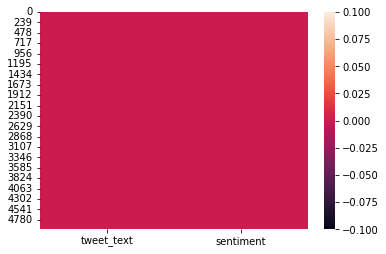

In [17]:
sns.heatmap(pd.isnull(base_teste));

# Função para pré-processamento dos textos

- Letras minúsculas
- Nome do usuário (@)
- URLs
- Espaços em branco
- Emoticons
- Stop words
- Lematização
- Pontuações

In [19]:
pln = spacy.load('pt')
pln

In [20]:
stop_words = spacy.lang.pt.stop_words.STOP_WORDS

In [21]:
def preprocessamento(texto):
  # Letras minúsculas
  texto = texto.lower()

  # Nome do usuário
  texto = re.sub(r"@[A-Za-z0-9$-_@.&+]+", ' ', texto)

  # URLs
  texto = re.sub(r"https?://[A-Za-z0-9./]+", ' ', texto)

  # Espaços em branco
  texto = re.sub(r" +", ' ', texto)

  # Emoticons
  lista_emocoes = {':)': 'emocaopositiva',
                   ':d': 'emocaopositiva',
                   ':(': 'emocaonegativa'}
  for emocao in lista_emocoes:
    texto = texto.replace(emocao, lista_emocoes[emocao])

  # Lematização
  documento = pln(texto)

  lista = []
  for token in documento:
    lista.append(token.lemma_)
  
  # Stop words e pontuações
  lista = [palavra for palavra in lista if palavra not in stop_words and palavra not in string.punctuation]
  lista = ' '.join([str(elemento) for elemento in lista if not elemento.isdigit()])
  
  return lista

# Pré-processamento da base de dados

# Limpeza dos textos

In [22]:
base_treinamento.head(10)

,tweet_text,sentiment
0,@Laranjito76 A pessoa certa para isso seria o ...,1
1,"@behin_d_curtain Para mim, é precisamente o co...",1
2,Vou fazer um video hoje... estou pensando em f...,1
3,"aaaaaaaa amei tanto essas polaroids, nem sei e...",1
4,Valoriza o coração do menininho que vc tem. El...,1
5,@KingJokerLeto mas amiga eu to aqui ainda :),1
6,"@RivasJairo Bravo, Jairo!!! :)))",1
7,@inquilinasls @Spotify socorro ksoaksosks acho...,1
8,"@chimekarlla gosto muito de fazenda :) , mas m...",1
9,Amanha vou ver venom :D,1


In [23]:
base_treinamento['tweet_text'] = base_treinamento['tweet_text'].apply(preprocessamento)

In [24]:
base_treinamento.head(10)

,tweet_text,sentiment
0,o pessoa certo parir seriar o valer e azeved...,1
1,parir mim precisamente o contrário emocaopos...,1
2,video hoje ... pensar falar sobrar o meter csg...,1
3,aaaaaaaa amar polaroids expressar o quantum to...,1
4,valorizar o coração menino vc diferente o sorr...,1
5,amigo to emocaopositiva,1
6,bravo jairo emocaopositiva,1
7,socorrer ksoaksosks achar to o caixa som :p,1
8,gostar fazenda emocaopositiva morrer medo ga...,1
9,amanhar venom emocaopositiva,1


In [25]:
base_teste['tweet_text'] = base_teste['tweet_text'].apply(preprocessamento)

In [26]:
base_teste.head(10)

,tweet_text,sentiment
0,obrigar emocaopositiva,1
1,pa puta parir emocaopositiva,1
2,querer desconto 14/08 ⭐ ⭐ ⭐ ⭐ ⭐ 🌐 conferir o l...,1
3,vcs ajudar galera pelar amor butera emocaoposi...,1
4,casar zé e o morrer sono chegar o casar e fica...,1
5,preciso emocaopositiva,1
6,acaso adorar beijo e abraço hahahahaha bue f...,1
7,solteiro s emocaopositiva,1
8,lindeza cortador kit mário coleção bia cravol ...,1
9,claro emocaopositiva,1


# Tratamento da classe

In [27]:
exemplo_base_dados = [["este trabalho é agradável", {"POSITIVO": True, "NEGATIVO": False}],
                      ["este lugar continua assustador", {"POSITIVO": False, "NEGATIVO": True}]]

In [28]:
base_dados_treinamento_final = []
for texto, emocao in zip(base_treinamento['tweet_text'], base_treinamento['sentiment']):
  if emocao == 1:
    dic = ({'POSITIVO': True, 'NEGATIVO': False})
  elif emocao == 0:
    dic = ({'POSITIVO': False, 'NEGATIVO': True})

  base_dados_treinamento_final.append([texto, dic.copy()])

In [29]:
len(base_dados_treinamento_final)

50000

In [30]:
base_dados_treinamento_final[10:15]

[['simplesmente o deixar chatear querer muitooo e iludir emocaopositiva',
  {'NEGATIVO': False, 'POSITIVO': True}],
 ['o comedir umar rotina e perfeitamente parir consolidar o escola condução :p',
  {'NEGATIVO': False, 'POSITIVO': True}],
 ['amigar parecer apaixonar vc — recíproco emocaopositiva',
  {'NEGATIVO': False, 'POSITIVO': True}],
 ['  gajar bacano aleijar esperar e o silvar feliz emocaopositiva',
  {'NEGATIVO': False, 'POSITIVO': True}],
 ['tou o video cabra bebé emocaopositiva',
  {'NEGATIVO': False, 'POSITIVO': True}]]

In [31]:
base_dados_treinamento_final[45000:45005]

[['o menino pijama listrar o filmar triste mundo estruturar nenhum pra assistir rever e to pensar n emocaonegativa',
  {'NEGATIVO': True, 'POSITIVO': False}],
 ['pra o vídeo luísa raiz o poliana infelizmente o twitter tá ruim amanhã postar emocaonegativa asaventurasdepoliana099',
  {'NEGATIVO': True, 'POSITIVO': False}],
 ['to crise abstinência strangers emocaonegativa — tbm :/ to',
  {'NEGATIVO': True, 'POSITIVO': False}],
 ['  esquecer olhar pra pagar o mensalidade turma pro cursar querer emocaonegativa',
  {'NEGATIVO': True, 'POSITIVO': False}],
 ['querer comer doce comer montar hoje emocaonegativa maldição',
  {'NEGATIVO': True, 'POSITIVO': False}]]

# Criação do classificador

In [32]:
modelo = spacy.blank('pt')
categorias = modelo.create_pipe("textcat")
categorias.add_label("POSITIVO")
categorias.add_label("NEGATIVO")
modelo.add_pipe(categorias)
historico = []

In [33]:
modelo.begin_training()
for epoca in range(5):
  random.shuffle(base_dados_treinamento_final)
  losses = {}
  for batch in spacy.util.minibatch(base_dados_treinamento_final, 512):
    textos = [modelo(texto) for texto, entities in batch]
    annotations = [{'cats': entities} for texto, entities in batch]
    modelo.update(textos, annotations, losses=losses)
    historico.append(losses)
  if epoca % 5 == 0:
    print(losses)

{'textcat': 1.0083012348983955e-05}


In [34]:
historico_loss = []
for i in historico:
  historico_loss.append(i.get('textcat'))

In [35]:
historico_loss = np.array(historico_loss)
historico_loss

array([1.00830123e-05, 1.00830123e-05, 1.00830123e-05, 1.00830123e-05,
       1.00830123e-05, 1.00830123e-05, 1.00830123e-05, 1.00830123e-05,
       1.00830123e-05, 1.00830123e-05, 1.00830123e-05, 1.00830123e-05,
       1.00830123e-05, 1.00830123e-05, 1.00830123e-05, 1.00830123e-05,
       1.00830123e-05, 1.00830123e-05, 1.00830123e-05, 1.00830123e-05,
       1.00830123e-05, 1.00830123e-05, 1.00830123e-05, 1.00830123e-05,
       1.00830123e-05, 1.00830123e-05, 1.00830123e-05, 1.00830123e-05,
       1.00830123e-05, 1.00830123e-05, 1.00830123e-05, 1.00830123e-05,
       1.00830123e-05, 1.00830123e-05, 1.00830123e-05, 1.00830123e-05,
       1.00830123e-05, 1.00830123e-05, 1.00830123e-05, 1.00830123e-05,
       1.00830123e-05, 1.00830123e-05, 1.00830123e-05, 1.00830123e-05,
       1.00830123e-05, 1.00830123e-05, 1.00830123e-05, 1.00830123e-05,
       1.00830123e-05, 1.00830123e-05, 1.00830123e-05, 1.00830123e-05,
       1.00830123e-05, 1.00830123e-05, 1.00830123e-05, 1.00830123e-05,
      

Text(0, 0.5, 'Erro')

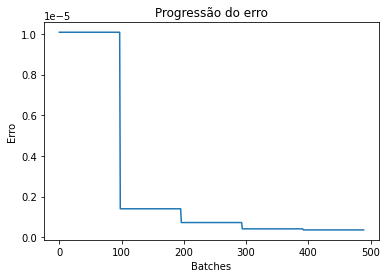

In [36]:
import matplotlib.pyplot as plt
plt.plot(historico_loss)
plt.title('Progressão do erro')
plt.xlabel('Batches')
plt.ylabel('Erro')

In [37]:
modelo.to_disk("modelo")

# Testes com uma frase

In [38]:
modelo_carregado = spacy.load('modelo')
modelo_carregado

# Texto positivo

In [39]:
texto_positivo = base_teste['tweet_text'][21]
texto_positivo

'  ficar feliz q recíproco emocaopositiva'

In [40]:
previsao = modelo_carregado(texto_positivo)
previsao

  ficar feliz q recíproco emocaopositiva

In [41]:
previsao.cats

{'NEGATIVO': 4.539786823443137e-05, 'POSITIVO': 0.9999545812606812}

In [42]:
texto_positivo = 'eu gosto muito de você'
texto_positivo = preprocessamento(texto_positivo)
texto_positivo

'gostar'

In [43]:
modelo_carregado(texto_positivo).cats

{'NEGATIVO': 0.26788103580474854, 'POSITIVO': 0.6051325798034668}

# Texto negativo

In [44]:
base_teste['tweet_text'][4000]

'tô triste filmar mulan o mushu emocaonegativa'

In [45]:
texto_negativo = base_teste['tweet_text'][4000]
previsao = modelo_carregado(texto_negativo)
previsao.cats

{'NEGATIVO': 0.9998012185096741, 'POSITIVO': 0.0002572822559159249}

# Avaliação do modelo

In [46]:
previsoes = []
for texto in base_teste['tweet_text']:
  previsao = modelo_carregado(texto)
  previsoes.append(previsao.cats)

In [47]:
previsoes_final = []
for previsao in previsoes:
  if previsao['POSITIVO'] > previsao['NEGATIVO']:
    previsoes_final.append(1)
  else:
    previsoes_final.append(0)

previsoes_final = np.array(previsoes_final)

In [48]:
respostas_reais = base_teste['sentiment'].values

In [49]:
from sklearn.metrics import accuracy_score
accuracy_score(respostas_reais, previsoes_final)

0.9964

A acurácia é  0.9964


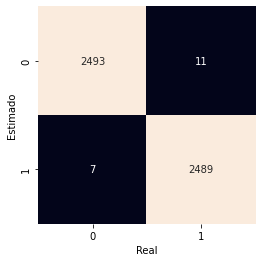

In [51]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(respostas_reais, previsoes_final)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('Real')
plt.ylabel('Estimado');
print('A acurácia é ',accuracy_score(respostas_reais, previsoes_final)) # exibe acurácia